In [128]:

import torch
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from BronchoTrack.metrics import DirectionError, EuclideanDistance, NeedleError

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 15,
    "font.size": 15,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.bottom" : True, 
    "ytick.left" : True,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
}

plt.rcParams.update(tex_fonts)

def compute_errors(data_vector):
    angles = torch.tensor(data_vector[3:6], dtype=torch.float32)
    pos = torch.tensor(data_vector[0:3], dtype=torch.float32)
    all_pa = torch.tensor(data_vector[0:6], dtype=torch.float32)
    ground = torch.zeros(3, dtype=torch.float32)
    ground_a = torch.ones(3, dtype=torch.float32)
    ground_extra = torch.zeros(6, dtype=torch.float32)
    de = DirectionError.inverse_cos(ground_a, angles).numpy()
    pe = EuclideanDistance.euclidean(ground, pos).numpy()
    ne = NeedleError.needle(ground_extra, all_pa).numpy()
    return [de, pe, ne]

def compute_distribution(globfolder):
    errors = []
    for csv in glob.glob(globfolder):
        df = pd.read_csv(csv, index_col=0).iloc[1:, 1:-1].values
        errors.append(np.apply_along_axis(compute_errors, 1, df))
    return np.concatenate(errors, 0)

In [129]:
train_errors = compute_distribution("./data/cleaned/train/*.csv")
val_errors = compute_distribution("./data/cleaned/val/*.csv")
test_errors = compute_distribution("./data/cleaned/test/*.csv")

In [134]:
def plot_error_dist(index, savepath, xlabel, ylabel=True):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.distplot(train_errors[:, index], bins=100, hist=False, kde_kws={"shade":True, "linewidth":1}, label="Train", ax=ax)
    ax = sns.distplot(test_errors[:, index], bins=100, hist=False, kde_kws={"shade":True, "linewidth":1}, label="Test", ax=ax)
    ax = sns.distplot(val_errors[:, index], bins=100, hist=False, kde_kws={"shade":True, "linewidth":1}, label="Val", ax=ax)

    ax.xaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    plt.legend(fontsize=20)
    plt.xlabel(xlabel, fontsize=25)
    if ylabel:
        plt.ylabel('Density', fontsize=25)
    fig.savefig(savepath, format='pdf', bbox_inches='tight')

/home/juan/miniconda3/envs/broncho/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/juan/miniconda3/envs/broncho/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/juan/miniconda3/envs/broncho/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot`

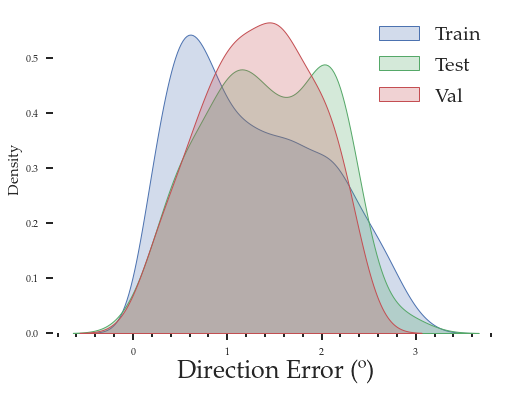

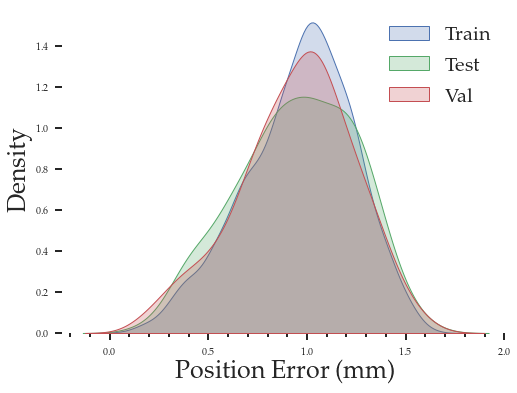

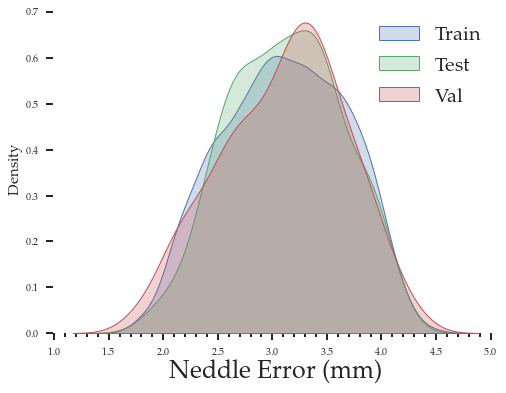

In [136]:
plot_error_dist(0, "images_paper/de.pdf", "Direction Error (º)", False)
plot_error_dist(1, "images_paper/pe.pdf", "Position Error (mm)", True)
plot_error_dist(2, "images_paper/ne.pdf", "Neddle Error (mm)", False)

